<a href="https://colab.research.google.com/github/Khoa-hub-commits/ANN/blob/main/Insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/200


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 - 2s - 54ms/step - loss: 0.0308 - mae: 0.1277 - percentage_within_tolerance: 0.5249 - val_loss: 0.0180 - val_mae: 0.0989 - val_percentage_within_tolerance: 0.6442
Epoch 2/200
34/34 - 0s - 5ms/step - loss: 0.0157 - mae: 0.0919 - percentage_within_tolerance: 0.6404 - val_loss: 0.0118 - val_mae: 0.0823 - val_percentage_within_tolerance: 0.6929
Epoch 3/200
34/34 - 0s - 9ms/step - loss: 0.0118 - mae: 0.0813 - percentage_within_tolerance: 0.6732 - val_loss: 0.0097 - val_mae: 0.0730 - val_percentage_within_tolerance: 0.7341
Epoch 4/200
34/34 - 0s - 5ms/step - loss: 0.0101 - mae: 0.0739 - percentage_within_tolerance: 0.6986 - val_loss: 0.0087 - val_mae: 0.0698 - val_percentage_within_tolerance: 0.7378
Epoch 5/200
34/34 - 0s - 10ms/step - loss: 0.0089 - mae: 0.0706 - percentage_within_tolerance: 0.7014 - val_loss: 0.0079 - val_mae: 0.0685 - val_percentage_within_tolerance: 0.7004
Epoch 6/200
34/34 - 0s - 9ms/step - loss: 0.0084 - mae: 0.0684 - percentage_within_tolerance: 0.7174 - val_los

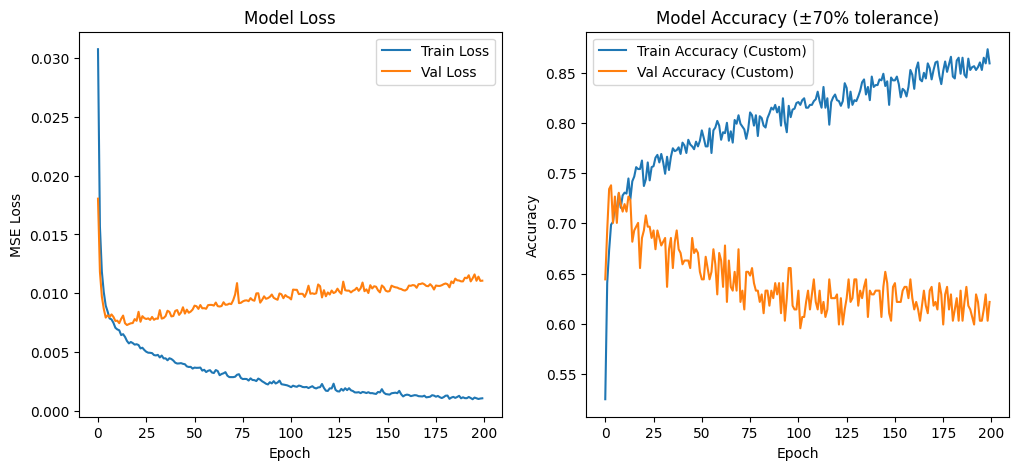

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Dự đoán (đơn vị gốc): 29610.20
Test MSE: 0.011066501960158348
Test MAE: 0.08176124095916748
Test Accuracy (±70%): 0.6217228174209595
Model saved to final_model.h5


In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import MeanAbsoluteError
from keras.models import save_model # Import save_model


# Define a custom metric for regression accuracy within a tolerance
class PercentageWithinTolerance(tf.keras.metrics.Metric):
    """
    Calculates the percentage of predictions within a given percentage tolerance of the true values.
    This is a custom metric for demonstration and not standard regression accuracy.
    """
    def __init__(self, name='percentage_within_tolerance', tolerance_percent=70, **kwargs): # Increased tolerance_percent to 70
        super(PercentageWithinTolerance, self).__init__(name=name, **kwargs)
        self.tolerance_percent = tolerance_percent
        self.total = self.add_weight(name='total', initializer='zeros', dtype=tf.int32)
        self.count = self.add_weight(name='count', initializer='zeros', dtype=tf.int32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, self._dtype)
        y_pred = tf.cast(y_pred, self._dtype)

        # Calculate tolerance as a percentage of the true value
        tolerance = self.tolerance_percent / 100.0 * tf.abs(y_true)
        # Set a reasonable minimum tolerance in the scaled space (e.g., 1% of the scaled range)
        min_tol = tf.constant(0.01, dtype=self._dtype) # Adjusted minimum tolerance
        tol = tf.maximum(tolerance, min_tol)


        correct_predictions = tf.less_equal(tf.abs(y_true - y_pred), tol)
        correct_predictions = tf.cast(correct_predictions, tf.int32)

        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self._dtype)
            correct_predictions = tf.multiply(correct_predictions, sample_weight)

        self.count.assign_add(tf.reduce_sum(correct_predictions))
        self.total.assign_add(tf.shape(y_true)[0])


    def result(self):
        # Avoid division by zero using tf.where
        return tf.where(tf.equal(self.total, 0),
                        tf.constant(0.0, dtype=tf.float32),
                        tf.cast(self.count, tf.float32) / tf.cast(self.total, tf.float32))


    def reset_state(self):
        # The state is reset at the start of each epoch by Keras.
        self.total.assign(0)
        self.count.assign(0)

    # Add this for serialization
    def get_config(self):
        config = super(PercentageWithinTolerance, self).get_config()
        config.update({'tolerance_percent': self.tolerance_percent})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


# ======================
# 1. Load dataset
# ======================
df = pd.read_csv("/content/insurance_data.csv")

# Đầu vào (features), đầu ra (claim)
X = df.drop("claim", axis=1)
y = df["claim"].astype(np.float32) # Ensure y is float32 for consistency

# ======================
# 2. Preprocessing
# ======================
categorical_cols = ["gender", "smoker", "region", "diabetic"]
numeric_cols = ["age", "bmi", "children", "bloodpressure"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(drop="first", sparse_output=False), categorical_cols) # Changed sparse=False to sparse_output=False
])

X_processed = preprocessor.fit_transform(X)

# Quan trọng: chuẩn hóa y về [0,1] để ANN học tốt
y_min, y_max = float(y.min()), float(y.max()) # Ensure min/max are floats
y_scaled = ((y - y_min) / (y_max - y_min)).astype(np.float32) # Corrected denominator

# Tách tập train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_scaled, test_size=0.2, random_state=42
)

# ======================
# Custom accuracy metric (tính trên scale gốc)
# ======================
# This custom metric is already defined and used in the compile step
# Renaming for clarity if needed in history plot access

# Instantiate the custom metric
custom_accuracy_metric = PercentageWithinTolerance(name='percentage_within_tolerance', tolerance_percent=70) # Increased tolerance_percent to 70

# tạo metric với tolerance 10% (bạn có thể đổi thành 5, 20, ...)
# The function is already defined globally, no need to redefine here


# ======================
# 3. Build ANN model
# ======================
model = Sequential([
    Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    Dense(32, activation="relu"),
    Dense(1, activation="linear")  # regression on scaled y
])

# Compile: loss = MSE, metrics: MAE + our accuracy
model.compile(optimizer="adam", loss="mse", metrics=[MeanAbsoluteError(name="mae"), custom_accuracy_metric]) # Use metric instance

# ======================
# 4. Train
# ======================
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=200, batch_size=32, verbose=2)

# ======================
# 5. Plot loss & accuracy
# ======================
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()

# Accuracy (custom)
plt.subplot(1,2,2)
plt.plot(history.history["percentage_within_tolerance"], label="Train Accuracy (Custom)")
plt.plot(history.history["val_percentage_within_tolerance"], label="Val Accuracy (Custom)")
plt.title("Model Accuracy (±70% tolerance)") # Updated title
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

# ======================
# 6. Dự đoán thử (lưu ý: giá trị category phải trùng với dữ liệu huấn luyện)
# ======================
sample = pd.DataFrame([{
    "age": 35,
    "gender": "Male", # Case corrected
    "bmi": 28.5,
    "children": 2,
    "smoker": "Yes", # Case corrected
    "region": "southeast",
    "bloodpressure": 90, # Added
    "diabetic": "Yes" # Added, case corrected
}])

# Chú ý: OneHotEncoder đã fit trên dữ liệu huấn luyện, input phải có cùng cased values
sample_processed = preprocessor.transform(sample)
pred_scaled = model.predict(sample_processed)[0][0]
pred = pred_scaled * (y_max - y_min) + y_min  # đảo chuẩn hóa
print(f"Dự đoán (đơn vị gốc): {pred:.2f}")

# ======================
# 7. Evaluate final (in metrics)
# ======================
eval_res = model.evaluate(X_test, y_test, verbose=0)
print("Test MSE:", eval_res[0])
print("Test MAE:", eval_res[1])
print("Test Accuracy (±70%):", eval_res[2]) # Updated tolerance in print statement

# ======================
# 8. Save model
# ======================
save_model(model, "final_model.h5") # Save the model
print("Model saved to final_model.h5")

In [77]:
import ipywidgets as widgets
from IPython.display import display, HTML, Image # Import Image
import pandas as pd
from keras.models import load_model # Import load_model
import tensorflow as tf # Import tensorflow for the custom metric
import keras.backend as K # Keep original import for now, but use tf.keras.backend below
from keras.losses import mean_squared_error # Import MSE function
import matplotlib.pyplot as plt # Import matplotlib for plotting


# Define a custom metric for regression accuracy within a tolerance (copied from training cell)
class PercentageWithinTolerance(tf.keras.metrics.Metric):
    """
    Calculates the percentage of predictions within a given percentage tolerance of the true values.
    This is a custom metric for demonstration and not standard regression accuracy.
    """
    def __init__(self, name='percentage_within_tolerance', tolerance_percent=70, **kwargs): # Increased tolerance_percent to 70
        super(PercentageWithinTolerance, self).__init__(name=name, **kwargs)
        self.tolerance_percent = tolerance_percent
        self.total = self.add_weight(name='total', initializer='zeros', dtype=tf.int32)
        self.count = self.add_weight(name='count', initializer='zeros', dtype=tf.int32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, self._dtype)
        y_pred = tf.cast(y_pred, self._dtype)

        # Calculate tolerance as a percentage of the true value
        tolerance = self.tolerance_percent / 100.0 * tf.abs(y_true)
        # Set a reasonable minimum tolerance in the scaled space (e.g., 1% of the scaled range)
        min_tol = tf.constant(0.01, dtype=self._dtype) # Adjusted minimum tolerance
        tol = tf.maximum(tolerance, min_tol)


        correct_predictions = tf.less_equal(tf.abs(y_true - y_pred), tol)
        correct_predictions = tf.cast(correct_predictions, tf.int32)

        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self._dtype)
            correct_predictions = tf.multiply(correct_predictions, sample_weight)

        self.count.assign_add(tf.reduce_sum(correct_predictions))
        self.total.assign_add(tf.shape(y_true)[0])


    def result(self):
        # Avoid division by zero using tf.where
        return tf.where(tf.equal(self.total, 0),
                        tf.constant(0.0, dtype=tf.float32),
                        tf.cast(self.count, tf.float32) / tf.cast(self.total, tf.float32))


    def reset_state(self):
        # The state is reset at the start of each epoch by Keras.
        self.total.assign(0)
        self.count.assign(0)

    # Add this for serialization
    def get_config(self):
        config = super(PercentageWithinTolerance, self).get_config()
        config.update({'tolerance_percent': self.tolerance_percent})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


# Load the saved model
try:
    # When loading, we need to provide the custom object and the loss function if it's causing issues
    # Although 'mse' is built-in, explicitly providing it might help
    custom_objects = {
        'PercentageWithinTolerance': PercentageWithinTolerance,
        'mse': mean_squared_error # Explicitly provide the MSE function
    }
    model = load_model("final_model.h5", custom_objects=custom_objects)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    model = None # Set model to None if loading fails

# Assuming y_min, y_max, preprocessor, X_test, y_test, and history are available from the training cell (80Gi3-r6t1su)
# If not, you would need to save/load these as well.
# For now, we'll assume they are in the environment.
# Added checks to ensure these variables are in the global scope and not None
y_min_available = 'y_min' in globals() and y_min is not None
y_max_available = 'y_max' in globals() and y_max is not None
preprocessor_available = 'preprocessor' in globals() and preprocessor is not None
X_test_available = 'X_test' in globals() and X_test is not None
y_test_available = 'y_test' in globals() and y_test is not None
history_available = 'history' in globals() and history is not None

# --- Debugging Prints ---
if history_available:
    print(f"History object available. ID: {id(history)}")
    if 'percentage_within_tolerance' in history.history:
        print(f"Final Training Accuracy from history: {history.history['percentage_within_tolerance'][-1]}")
        print(f"Final Validation Accuracy from history: {history.history['val_percentage_within_tolerance'][-1]}")
else:
    print("History object not available.")
# --- End Debugging Prints ---


# Calculate overall custom accuracy on the test set (if components available)
overall_test_accuracy = None
if model is not None and X_test_available and y_test_available:
    try:
        # Explicitly evaluate the model once to build metrics
        eval_res_initial = model.evaluate(X_test, y_test, verbose=0)
        if eval_res_initial is not None and len(eval_res_initial) > 1: # Check if there's more than just the loss
             # Find the index of the custom metric
             custom_metric_index = None
             if hasattr(model, 'metrics'):
                 for i, metric in enumerate(model.metrics):
                     if isinstance(metric, PercentageWithinTolerance) or (hasattr(metric, 'name') and metric.name == 'percentage_within_tolerance'):
                          custom_metric_index = i
                          break

             if custom_metric_index is not None and custom_metric_index < len(eval_res_initial):
                 overall_test_accuracy = eval_res_initial[custom_metric_index] * 100
             else:
                  print("Warning: Custom accuracy metric 'percentage_within_tolerance' not found in model metrics after loading for initial overall test accuracy calculation.")

        else:
             print("Warning: No metrics found in model evaluation results for initial overall test accuracy calculation.")

    except Exception as e:
        print(f"Error calculating initial overall accuracy: {e}")

# Get final training accuracy (if history available)
final_train_accuracy = None
if history_available and 'percentage_within_tolerance' in history.history:
    final_train_accuracy = history.history['percentage_within_tolerance'][-1] * 100


# Tạo input widgets
age_widget = widgets.IntSlider(min=18, max=100, value=35, description="Age")
gender_widget = widgets.Dropdown(options=["Male", "Female"], value="Male", description="Gender")
bmi_widget = widgets.FloatSlider(min=10, max=60, step=0.1, value=28.5, description="BMI")
children_widget = widgets.IntSlider(min=0, max=5, value=2, description="Children")
smoker_widget = widgets.Dropdown(options=["Yes", "No"], value="Yes", description="Smoker")
region_widget = widgets.Dropdown(
    options=["southwest", "southeast", "northwest", "northeast"],
    value="southeast",
    description="Region"
)

# Group widgets for better layout
demographics_group = widgets.VBox([
    widgets.Label("Demographic Information:"),
    age_widget,
    gender_widget,
    children_widget
])

health_group = widgets.VBox([
    widgets.Label("Health Information:"),
    bmi_widget,
    smoker_widget,
    # Note: bloodpressure and diabetic are in the data but not in the widget as per previous request
])

location_group = widgets.VBox([
    widgets.Label("Location Information:"),
    region_widget
])


input_widgets = widgets.VBox([
    widgets.Label("Enter Patient Information:"),
    demographics_group,
    health_group,
    location_group
])


# Nút bấm và output
button = widgets.Button(description="🔮 Predict", button_style="success")
output = widgets.Output()
plot_output = widgets.Output() # Output widget for plot


def on_predict_clicked(b):
    if model is None:
        with output:
            output.clear_output()
            display(HTML("<h3 style='color:red'>Model not loaded. Cannot predict.</h3>"))
        return

    if not preprocessor_available or not y_min_available or not y_max_available:
         with output:
            output.clear_output()
            display(HTML("<h3 style='color:red'>Preprocessing components (preprocessor, y_min, y_max) not found. Cannot predict. Please run the training cell first.</h3>"))
         return


    # Create dataframe from widget values
    sample_dict = {
        "age": age_widget.value,
        "gender": gender_widget.value,
        "bmi": bmi_widget.value,
        "children": children_widget.value,
        "smoker": smoker_widget.value,
        "region": region_widget.value
    }


    # Add missing columns with default values (index, PatientID, bloodpressure, diabetic)
    # Get original columns from X (before processing)
    # Assuming 'df' is available from the training cell (80Gi3-r6t1su)
    if 'df' in globals():
        original_cols = df.drop("claim", axis=1).columns.tolist()
        # Create a dictionary to hold sample data with default values that are valid for preprocessing
        full_sample_dict = {}
        for col in original_cols:
            if col in categorical_cols:
                if df is not None and not df[col].empty:
                    full_sample_dict[col] = df[col].mode()[0]
                else:
                     full_sample_dict[col] = ""
            elif col in numeric_cols:
                 full_sample_dict[col] = 0
            else:
                 full_sample_dict[col] = 0


        # Update values from widgets for the 6 selected columns
        # Using a dictionary lookup for widget values
        widget_values = {w.description.lower().replace(" ", ""): w.value for w in [age_widget, gender_widget, bmi_widget, children_widget, smoker_widget, region_widget]}

        for col in full_sample_dict.keys():
            # Match column name to widget description (case-insensitive, no spaces)
            col_lower_no_space = col.lower().replace(" ", "")
            if col_lower_no_space in widget_values:
                full_sample_dict[col] = widget_values[col_lower_no_space]


        sample_df_full = pd.DataFrame([full_sample_dict])


        sample_proc = preprocessor.transform(sample_df_full) # Use the full DataFrame

        pred_scaled = model.predict(sample_proc, verbose=0)[0,0]
        pred = pred_scaled * (y_max - y_min) + y_min # Inverse scaling

        with output:
            output.clear_output()
            display(HTML(f"<h3 style='color:green'>Predicted Charges: ${pred:,.2f}</h3>"))

            # Display final training accuracy if available
            if final_train_accuracy is not None:
                 # Updated tolerance text to 70%
                 display(HTML(f"<p>Final Training Accuracy (within 70% tolerance): {final_train_accuracy:.2f}%</p>"))

            # Display overall test set accuracy if calculated (use overall_test_accuracy calculated initially)
            if overall_test_accuracy is not None:
                 # Updated tolerance text to 70%
                 display(HTML(f"<p>Overall Test Set Accuracy (within 70% tolerance): {overall_test_accuracy:.2f}%</p>"))
            elif X_test_available and y_test_available and model is not None:
                 # Fallback: If overall_test_accuracy wasn't calculated initially but components are available, try calculating here
                 try:
                     results = model.evaluate(X_test, y_test, verbose=0)
                     if results is not None and len(results) > 1:
                         custom_metric_index = None
                         if hasattr(model, 'metrics'):
                             for i, metric in enumerate(model.metrics):
                                 if isinstance(metric, PercentageWithinTolerance) or (hasattr(metric, 'name') and metric.name == 'percentage_within_tolerance'):
                                     custom_metric_index = i
                                     break

                         if custom_metric_index is not None and custom_metric_index < len(results):
                             current_overall_test_accuracy = results[custom_metric_index] * 100
                             # Updated tolerance text to 70%
                             display(HTML(f"<p>Overall Test Set Accuracy (within 70% tolerance): {current_overall_test_accuracy:.2f}%</p>"))
                         else:
                              display(HTML("<p>Warning: Custom accuracy metric 'percentage_within_tolerance' not found after loading. Cannot display overall test accuracy.</p>"))
                     else:
                          display(HTML("<p>Warning: No metrics found in model evaluation results. Cannot display overall accuracy.</p>"))

                 except Exception as e:
                     display(HTML(f"<p>Error calculating overall accuracy: {e}</p>"))

        # --- Placeholder for Plotting and Saving Image ---
        with plot_output:
            plot_output.clear_output(wait=True) # Clear previous plot
            plt.figure(figsize=(12,5)) # Use a larger figure size for two plots

            # Loss plot
            plt.subplot(1,2,1)
            if history_available and 'loss' in history.history and 'val_loss' in history.history:
                 plt.plot(history.history["loss"], label="Train Loss")
                 plt.plot(history.history["val_loss"], label="Val Loss")
                 plt.title("Model Loss")
                 plt.xlabel("Epoch")
                 plt.ylabel("MSE Loss")
                 plt.legend()
            else:
                 plt.text(0.5, 0.5, "Loss plot not available", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
                 plt.title("Model Loss")


            # Accuracy plot (custom)
            plt.subplot(1,2,2)
            if history_available and 'percentage_within_tolerance' in history.history and 'val_percentage_within_tolerance' in history.history:
                 plt.plot(history.history["percentage_within_tolerance"], label="Train Accuracy (Custom)")
                 plt.plot(history.history["val_percentage_within_tolerance"], label="Val Accuracy (Custom)")
                 plt.title("Model Accuracy (±70% tolerance)") # Updated title
                 plt.xlabel("Epoch")
                 plt.ylabel("Accuracy")
                 plt.legend()
            else:
                 plt.text(0.5, 0.5, "Accuracy plot not available", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
                 plt.title("Model Accuracy")

            # Add input feature information as text to the plot
            input_info_text = "Input Features:\n"
            for col, value in sample_dict.items():
                input_info_text += f"{col}: {value}\n"

            # Add text to the figure (adjust coordinates as needed)
            # Using fig.text to place text relative to the figure
            plt.gcf().text(0.02, 0.98, input_info_text, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))


            plt.tight_layout() # Adjust layout
            plt.show()

            # Placeholder for saving the plot image
            # You would define a filename based on inputs or timestamp
            image_filename = 'final_plot.png' # Define filename
            plt.savefig(image_filename) # Save the plot
            print(f"Plot saved to {image_filename}") # Optional confirmation message
            plt.close() # Close the plot to free up memory

            # Display the saved image
            display(Image(filename=image_filename)) # Display the saved image
        # --- End Placeholder ---


    else:
         with output:
            output.clear_output()
            display(HTML("<h3 style='color:red'>Original DataFrame (df) not found. Cannot preprocess sample data. Please run the training cell first.</h3>"))


button.on_click(on_predict_clicked)

# Hiển thị giao diện
display(input_widgets, button, output, plot_output)

Model loaded successfully.
History object available. ID: 137136790446176
Final Training Accuracy from history: 0.8591549396514893
Final Validation Accuracy from history: 0.6217228174209595


Button(button_style='success', description='🔮 Predict', style=ButtonStyle())

Output()

Output()